# Anatomy of a GPT

![Anatomy of a GPT](../assets/anatomy-of-a-gpt.jpg)

In [1]:
import sys

sys.path.append("../src")
import train

In [2]:
run = train.Run.from_file(
    "../runs/nlab-gpt-10.1M-77f6a21a/nlab-gpt-10.1M-77f6a21a-14000-best-9.54.pt"
)
run.model.to("cpu")

Transformer(
  (embed_tokens): Embedding(8192, 256)
  (embed_positions): Embedding(512, 256)
  (embed_dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x DecoderLayer(
      (input_layernorm): RMSNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attn): GroupedQueryAttention(
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (kv_proj): Linear(in_features=256, out_features=256, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (o_proj): Linear(in_features=256, out_features=256, bias=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (post_attention_layernorm): RMSNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=False)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=False)
          (3): Dropout(p=0.1, inp

In [3]:
import tokenizers

tokenizer = tokenizers.Tokenizer.from_file("../data/tokenizer.json")

In [19]:
text = r"a coend is a weighted colimit along the hom functor"

input_ids = tokenizer.encode(text).ids
labels = [tokenizer.decode([token]) for token in input_ids]

print(f"The sentence:\n    {text}\ngets broken down into tokens:\n    {labels}")

The sentence:
    a coend is a weighted colimit along the hom functor
gets broken down into tokens:
    ['a', ' co', 'end', ' is', ' a', ' weight', 'ed', ' colimit', ' along', ' the', ' hom', ' functor']


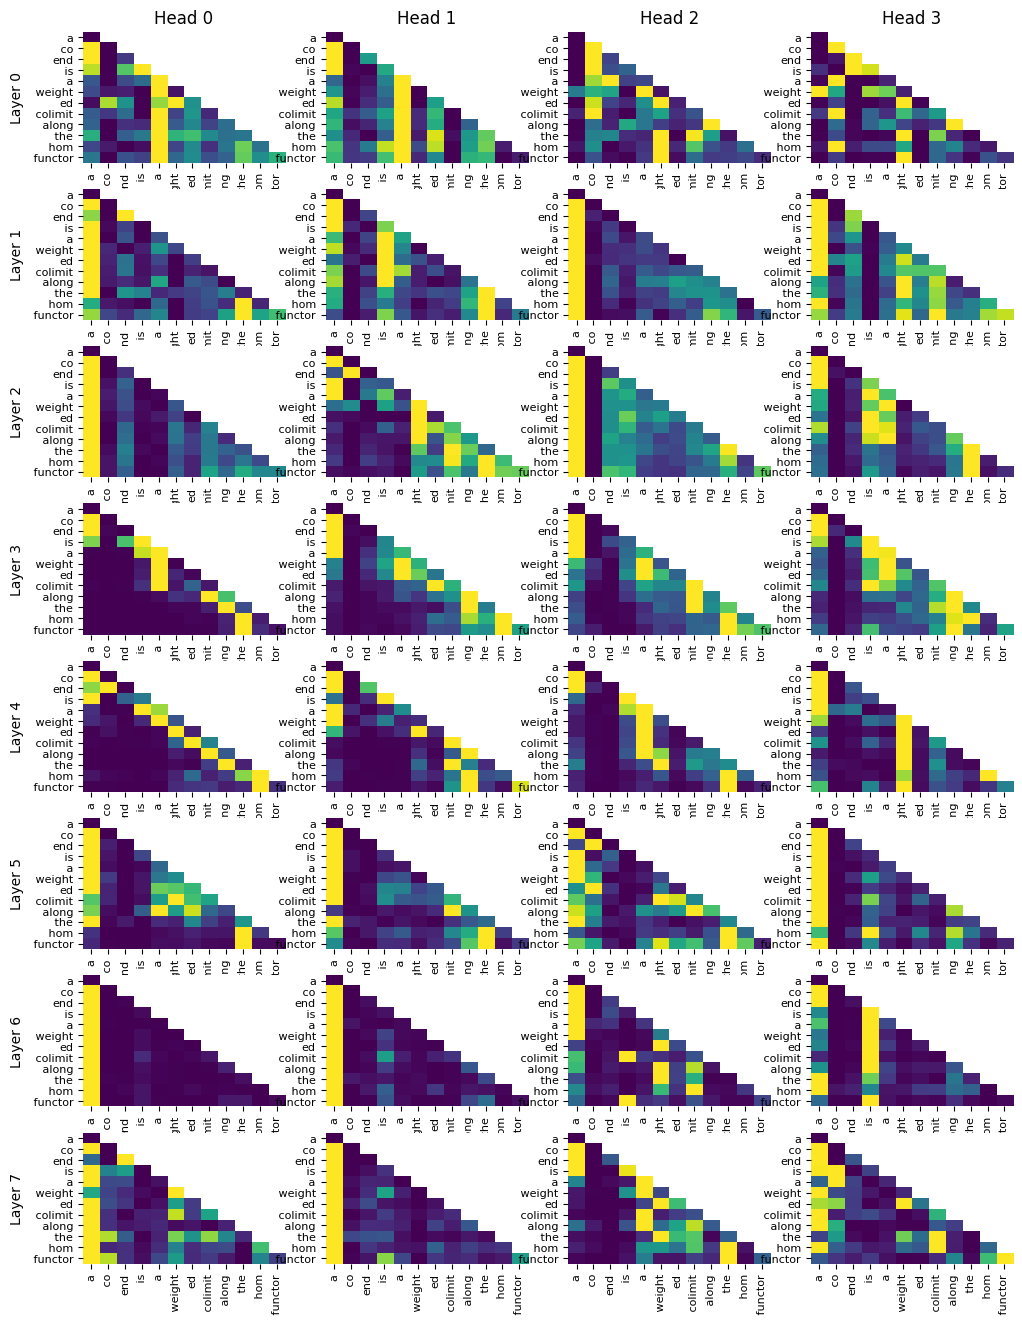

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

fig, axes = plt.subplots(
    run.config.num_hidden_layers,
    run.config.num_attention_heads,
    figsize=(12, 2 * run.config.num_hidden_layers),
)


def attention_callback(layer, head, attn_weights):
    attn_weights = np.ma.masked_equal(attn_weights, 0.0)

    A = attn_weights.filled(np.nan).astype(float)

    row_min = np.nanmin(A, axis=1, keepdims=True)
    row_max = np.nanmax(A, axis=1, keepdims=True)
    den = row_max - row_min

    normalized = np.divide(
        A - row_min,
        den,
        out=np.zeros_like(A, dtype=float),
        where=(den != 0) & np.isfinite(den),
    )

    ax = axes[layer, head]
    ax.imshow(
        np.ma.array(normalized, mask=np.triu(np.ones_like(A, dtype=bool), k=1)),
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="viridis",
        interpolation="nearest",
        origin="upper",
    )

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90, fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)

    if layer == 0:
        ax.set_title(f"Head {head}")
    if head == 0:
        ax.set_ylabel(f"Layer {layer}")

    for spine in ax.spines.values():
        spine.set_visible(False)


run.model(
    torch.tensor([input_ids], device="cpu"),
    attention_callback=attention_callback,
)

plt.show()